In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sounddevice as sd

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
import mdct
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')

def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,data)
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [3]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [4]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [5]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

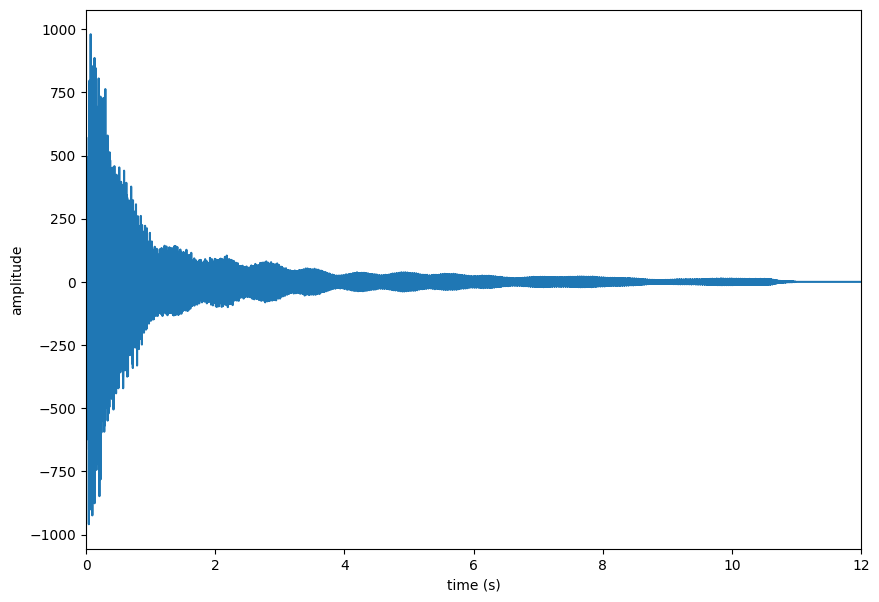

In [6]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

# Implémentation des fonctions Haute Résolution

On considère que le signal à analyser est de la forme :
$$
s[t] = \sum_{k=0}^{K-1} \alpha_k z_k^t
$$
avec 
\begin{align*}
    \alpha_k &=a_ke^{i\varphi_k} \\
    z_k &= e^{\delta_k + 2i\pi f_k}\\
    K &\text{ le nombre de fréquences contenues dans x}
\end{align*}
## MUSIC 
On définit la matrice de Hankel X contenant le signal x observé.

In [26]:
def Hankel(signal, n, l):
    X = np.zeros((n,l), dtype=np.complex_)
    for col in range(l):
        X[:,col] = signal[col:col+n]
    return X

def corrMatrix(X: np.array):
    return np.dot(X, X.conj().T) / X.shape[1]


def separation(W: np.array, n: int):
    W_signal = W[:, :n]
    W_ortho = W[:, n:]
    return W_signal, W_ortho


def normeMUSIC(W_ortho: np.array, v_n: np.array):
    a = np.dot(W_ortho.conj().T, v_n)
    return 1 / np.square(np.linalg.norm(a))


def genere_espace_test(delta_range: tuple, freq_range: tuple):
    freq = np.arange(*freq_range)
    delta = np.arange(*delta_range)
    z = np.zeros((len(delta), len(freq)), dtype=np.complex_)
    for i, d in enumerate(delta):
        for j, f in enumerate(freq):
            z[i, j] = np.exp(2 * 1j * pi * f + d)
    return z


def matrixMUSIC(
    W_ortho: np.array,
    n: int,
    delta_range: tuple,
    freq_range: tuple,
):
    z = genere_espace_test(delta_range, freq_range)
    v_n = np.zeros((n, 1), dtype=np.complex_)
    M = np.zeros(z.shape)
    print(f"Nombre de pas {z.shape[0]*z.shape[1]}")
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            v_n[:, 0] = np.power(z[i, j] * np.ones(n), np.arange(n))
            M[i, j] = normeMUSIC(W_ortho, v_n)
            print(f"{i*z.shape[1]+j+1}{' '*5}", end="\r")
    return M


def plotMUSIC(mat, V, n_freq):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(V[: n_freq + 1].real)
    axs[0].set_title("Valeurs propres")
    c = axs[1].imshow(np.log(np.absolute(mat)), cmap="inferno")
    fig.colorbar(c)
    axs[1].axis("auto")
    axs[1].set_ylabel("Delta")
    axs[1].set_xlabel("Fréquence réduite")
    axs[1].set_xticks(np.arange(0, mat.shape[1], mat.shape[1] // 10))
    axs[1].set_xticklabels(
        np.arange(0, mat.shape[1], mat.shape[1] // 10) / mat.shape[1]
    )
    axs[1].set_yticks(np.arange(0, mat.shape[0] + 1, mat.shape[0] // 5))
    axs[1].set_yticklabels(
        np.round(
            0.2 * np.arange(0, mat.shape[0] + 1, mat.shape[0] // 5) / mat.shape[0]
            - 0.1,
            2,
        )
    )
    axs[1].set_title("Matrice MUSIC")
    plt.show()
    plot3D(mat)


def plot3D(mat):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X = np.arange(mat.shape[0])
    Y = np.arange(mat.shape[1])
    X, Y = np.meshgrid(X, Y)
    Z = np.log(np.absolute(mat[X, Y]))
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel("Delta")
    ax.set_ylabel("Fréquence réduite")
    ax.set_yticks(np.arange(0, mat.shape[1], mat.shape[1] // 10))
    ax.set_yticklabels(
        np.arange(0, mat.shape[1], mat.shape[1] // 10) / mat.shape[1]
    )
    ax.set_xticks(np.arange(0, mat.shape[0] + 1, mat.shape[0] // 5))
    ax.set_xticklabels(
        np.round(
            0.2 * np.arange(0, mat.shape[0] + 1, mat.shape[0] // 5) / mat.shape[0]
            - 0.1,
            2,
        )
    )
    ax.view_init(20,5)
    plt.show()


def MUSIC(
    signal: np.array,
    n_freq: int,
    n:int,
    l:int,
    f_range: tuple,
    d_range: tuple,
    show: bool = True,
):
    # X = Hankel(signal, n, l)
    X = hankel(signal)
    Rxx = corrMatrix(X)
    V, W = np.linalg.eig(Rxx)
    W_signal, W_bruit = separation(W, n_freq)
    mat = matrixMUSIC(W_bruit, X.shape[0], d_range, f_range)
    if show:
        plotMUSIC(mat, V, n_freq)
    return mat

In [29]:
test = np.arange(20)
with np.printoptions(linewidth=np.inf, edgeitems=10):
    print(Hankel(test, 10, 9).real)
    print(hankel(test))
# test = np.ones((5,5))
# print(*separation(test,test,2))
# test = np.diag([10,4,5,7,3])
# print(diagonaliser(test))
# test = 2
# print(np.power(test*np.ones(5), np.arange(5)))

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 4.  5.  6.  7.  8.  9. 10. 11. 12.]
 [ 5.  6.  7.  8.  9. 10. 11. 12. 13.]
 [ 6.  7.  8.  9. 10. 11. 12. 13. 14.]
 [ 7.  8.  9. 10. 11. 12. 13. 14. 15.]
 [ 8.  9. 10. 11. 12. 13. 14. 15. 16.]
 [ 9. 10. 11. 12. 13. 14. 15. 16. 17.]]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0]
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  0]
 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  0  0]
 [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  0  0  0]
 [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  0  0  0  0]
 [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  0  0  0  0  0]
 [ 7  8  9 10 11 12 13 14 15 16 17 18 19  0  0  0  0  0  0  0]
 [ 8  9 10 11 12 13 14 15 16 17 18 19  0  0  0  0  0  0  0  0]
 [ 9 10 11 12 13 14 15 16 17 18 19  0  0  

## ESPRIT

# Signal synthétique


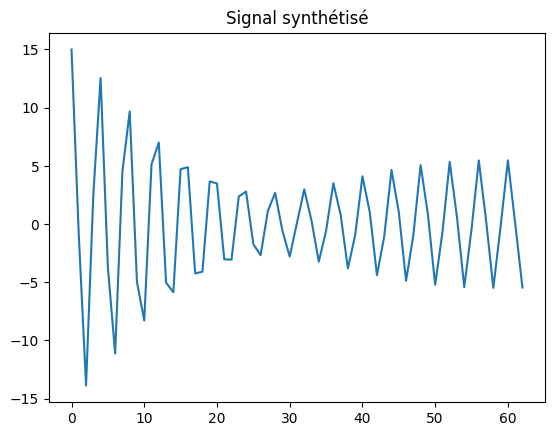

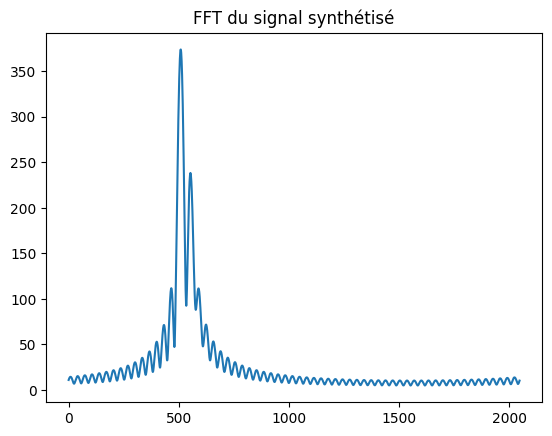

In [20]:
# Définition du signal synthétique
delta = np.array([0, -0.05])
N = 63
f0=1/4
f = np.array([f0, f0+1/N])
a = np.array([5, 10])
phi = np.array([0, 0])
synth = Synthesis(N, delta, f, a, phi)

plt.plot(synth.real)
plt.title("Signal synthétisé")
plt.show()
plt.plot(abs(np.fft.fft(synth,2048)))
plt.title("FFT du signal synthétisé")
plt.show()

## MUSIC

Nombre de pas 20000


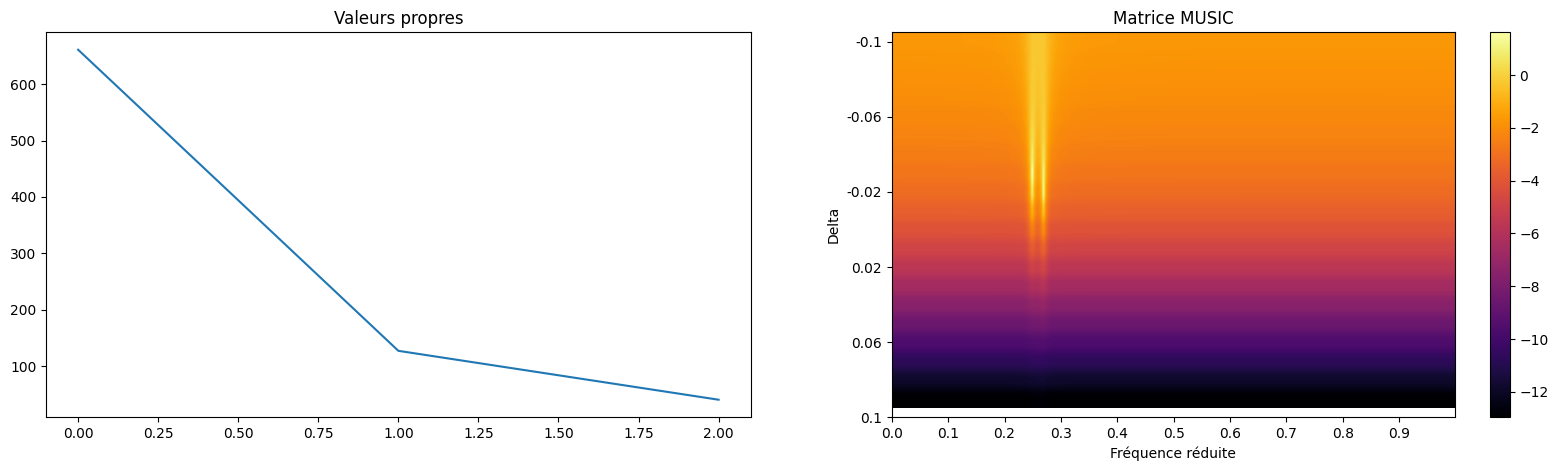

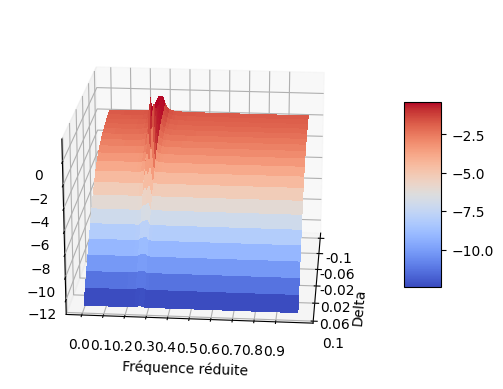

In [27]:
f_range = (0, 1, 0.001)
d_range = (-0.1, 0.1, 0.01)
n = 40
l = len(synth) - n + 1
m=MUSIC(synth, 2, n, l, f_range, d_range)

## ESPRIT

In [11]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

# Signaux réels 
Cloche A :

In [12]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')


## MUSIC


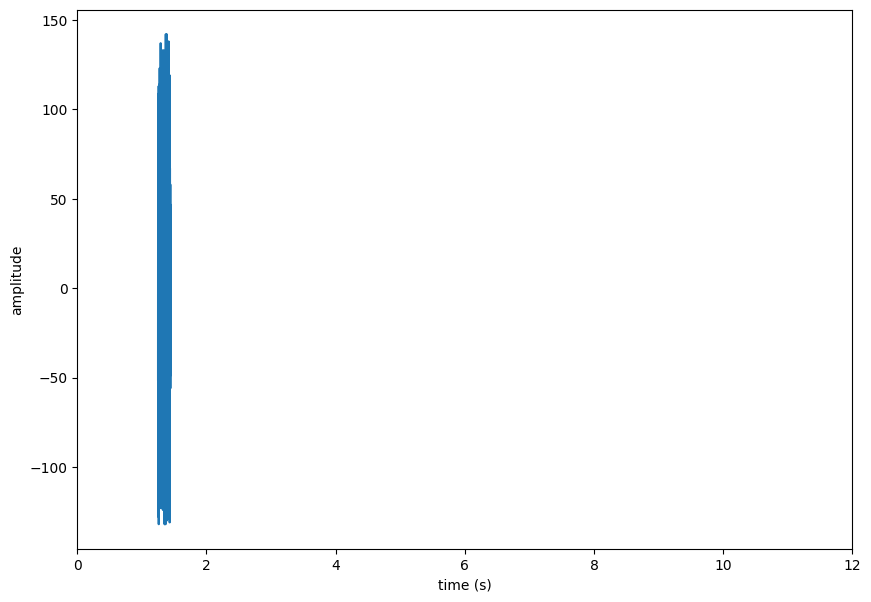

Nombre de pas 200


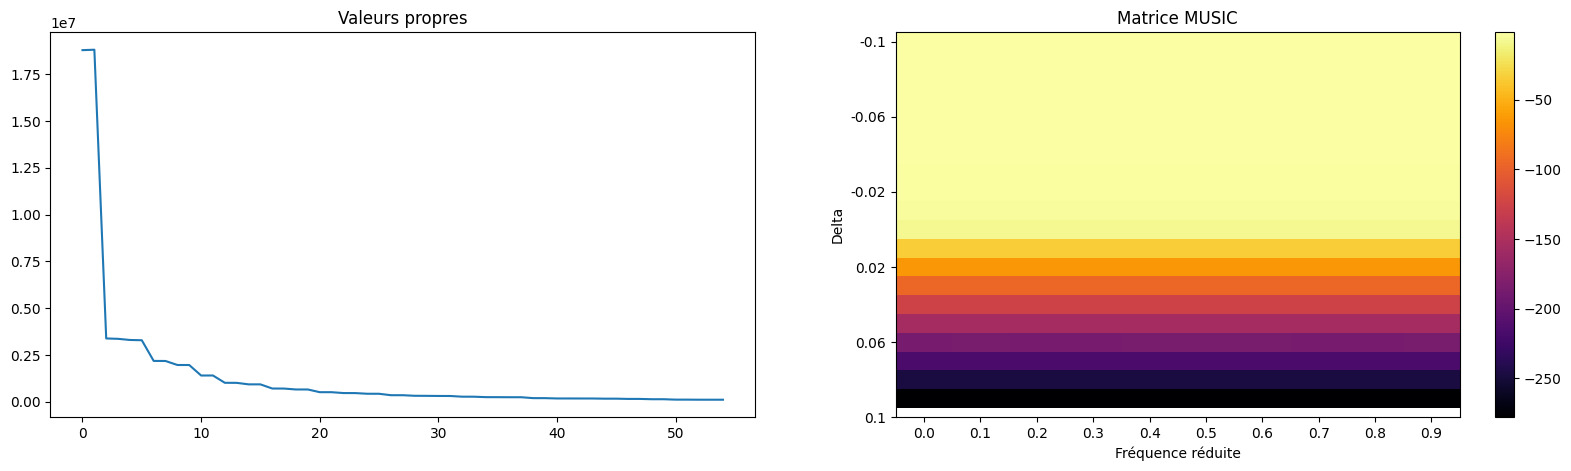

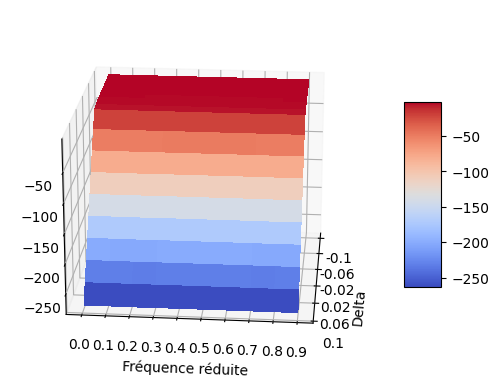

In [30]:
f_range = (0, 1, 0.1)
d_range = (-0.1, 0.1, 0.01)
K = 54
n = 512
l = 2*n
N = n + l - 1
times = np.arange(data.shape[1]) / sampling_frequency
offset = 10000
truncated_data = data.reshape(data.shape[1])[offset : offset + N]
plot_sound(truncated_data, times[offset : offset + N], 0, 12, w=10, h=7)
m = MUSIC(data.reshape(data.shape[1])[:N], K, n, l, f_range, d_range)